# European Electricity Data Preliminary Analysis


**Data source and dictionary:** https://data.open-power-system-data.org/time_series/2019-06-05 

### Data Sources
Internet Source: https://github.com/LSB-dev/Publicly-Available-Datasets-For-Electric-Load-Forecasting?tab=readme-ov-file

Citation(s): 
- Baur, L.; Chandramouli, V.; Sauer, A.: Publicly Available Datasets For Electric Load Forecasting – An Overview. In: Herberger, D.; Hübner, M. (Eds.): Proceedings of the CPSL 2024. Hannover : publish-Ing., 2024, S. 1-12. DOI: https://doi.org/10.15488/17659

- Open Power System Data. 2020. Data Package Time series. Version 2020-10-06. https://doi.org/10.25832/time_series/2020-10-06. (Primary data from various sources, for a complete list see URL).

Details on how the Data was processed:
https://github.com/Open-Power-System-Data/time_series/blob/885c0946fe57d1a2f44f7bc57306e87811e4e2e8//processing.ipynb

### Setup

In [1]:
### Import packages
import pandas as pd
import missingno
from datetime import datetime
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Notebook Config
%config InteractiveShell.ast_node_interactivity = 'all'

# Data Dictionary
# https://data.open-power-system-data.org/time_series/2019-06-05


In [134]:
# Functions
def country_level_variables(df, load_only=False):
    '''
    Description: Takes dataframe of variables and seperates them in groups 
    according to the first two letters of the variable.

    Inputs: Energy Dataframe
        load_only: To ONLY include the load_actual_entsoe_transparency variable 
        for a country instead of all variables. 
    Output: Dictionary of countries and their associated variables
    '''
    # Get all unique two-letter prefixes
    countries = set(col[:2] for col in df.columns if col not in ['utc_timestamp', 'cet_cest_timestamp'])
    
    # Dictionary to store results
    group_dfs = {}
    
    if load_only:
        for country in countries:
            # Load actual variable
            load_only_var = country + '_load_actual_entsoe_transparency'

            # Variables to subset to
            all_cols = ['utc_timestamp', load_only_var]
            
            # Create dataframe for country and assign to dictionary
            group_df = df[all_cols].copy() 
            group_dfs[country] = pd.DataFrame(group_df)
            
            # Create global variable for each group
            globals()[country] = group_df

    else:
        # Create dataframe for each prefix
        for country in countries:
            # Get columns that start with the prefix
            country_cols = [col for col in df.columns if col.startswith(country)]
            
            # Add time variables
            time_col = ['utc_timestamp']
            all_cols = time_col + country_cols
            
            # Create dataframe for country and assign to dictionary
            group_df = df[all_cols].copy() 
            group_dfs[country] = pd.DataFrame(group_df)
            
            # Create global variable for each group
            globals()[country] = group_df
    
    return group_dfs #pd.DataFrame(group_dfs)

def country_missing_dt(country_dfs):
    '''
    Description: Create missing data plots per country

    Input: Dictionary of countries and their data 
          (from country_level_variables function)
    Output: Graphs of missing data by variable
    '''
    for country, data in country_dfs.items():
        # Ensure data is ordered
        data = data.sort_values(by='utc_timestamp')
        # Return missing data for given country
        print(f"Country: {country} has {data.shape[1]} columns")
        missingno.matrix(data, figsize=(8,5), fontsize=12)

#### Perhaps a section for one off functions or quality of life or something?

############# class DataPrep?
# class DataPrep:
#     def __init__(self, df):
#         # store df
#         self.df = df
    
#         # # for transformations after initialization
#         # self.with_time_features = self.add_time_features(df)
#         # self.hrly_pivot = self.hourly_pivot(df)  ## self.with_time_features
#         # self.norm_avg_hrly = self.norm_avg_hourly(df) ## self.hrly_pivot
#         # #self.multi_lineplots =

def add_time_features(df): # requires country_actuals dataframe
    '''
    Description: Given country_actuals dataset derived from 
    country_level_variables method + .reset_index(), adds
    several simple time features ('day', 'hour', 'week' ########################################################################## adjust
    'is_weekend' indicator, and 'is_holiday' indicator)
    '''
    us_holidays = holidays.US(years=range(2014, 2021))
    # day level date
    df['day'] = df['utc_timestamp'].dt.date
    # hour
    df['hour'] = df['utc_timestamp'].dt.hour
    # week - would like first week to be 0 and last week to by multiple of year * week 
    df['week1'] = df['utc_timestamp'].dt.isocalendar().week
    # weekend indicator variable
    df['is_weekend'] = df['utc_timestamp'].dt.dayofweek.isin([5, 6]).astype(int)
    # holiday indicator variable
    df['is_holiday'] = df['utc_timestamp'].dt.date.isin(us_holidays).astype(int)

    return df

def hourly_pivot(df): # requires country actuals
    '''
    Description: pivots table long-ways, with country and aggregated hourly 
    actuals load as columns
    '''
    return (df.pivot_table(index=['day', 'country'], 
                        values='load_actual_entsoe_transparency', 
                        columns = 'hour', 
                        aggfunc='sum')
                        # remove first day with NaNs
            .dropna()
            .reset_index(level=1))

def plot_norm_avg_hourly(df, group, pivot=True): # requires df from hourly_pivot function
    '''
    Description: min-max normalization of input data across each hour
    '''
    df = df.groupby(by=group, as_index=False).mean().round(2)
    # hour columns
    cols = list(range(24))

    # columns for row-wise min-max normalization
    df['min'] = df[cols].min(axis=1)
    df['max'] = df[cols].max(axis=1)

    # Row-wise Min-max normalization 
    df[cols] = (df[cols].sub(df['min'], axis=0)
                        .div(df['max'] - df['min'], axis=0))
    
    # Melt for overlapping lineplots
    if pivot:
        df = (df.reset_index()
                .melt(id_vars=group,
                    value_vars=cols)
                .assign(hour = lambda x: pd.to_numeric(x.hour))
                )
        
    return df

def multi_lineplots(plot_df, group, clusters=False): # requires df from norm_avg_hourly function  
    '''
    Description: Creates overlapping line plots for each country given a dataframe
    from the 'norm_avg_hourly' function.
    '''
    colors = sns.color_palette('magma')
    _ = plt.figure(figsize=(10, 6))

    if clusters==False:
        for grouping, color in zip(plot_df[group].unique(), colors):
            line_plot = (plot_df[plot_df[group] == grouping].reset_index() # comment out reset index?
                         .groupby(group, as_index=False).mean())
            _ = sns.lineplot(
                data=line_plot,
                x='hour',
                y='value',
                color=color,
                label = str(grouping)
            )
        _ = plt.xlabel('Hour')
        _ = plt.ylabel('Min-Max Normalized Load Actual')
        _ = plt.title('Average Normalized Load Shapes by Country 2015-2019')
        
    if clusters:
        line_plot = plot_df.groupby(group, as_index=False).mean()
        line_plot = plot_norm_avg_hourly(line_plot, group)
        for grouping, color in zip(plot_df[group].unique(), colors):
            _ = sns.lineplot(
                data=line_plot,
                x='hour',
                y='value',
                color=color,
                label = str(grouping)
                )
            _ = plt.xlabel('Hour')
            _ = plt.ylabel('Min-Max Normalized Load Actual')
            _ = plt.title('Normalized Load Shapes of Countries Averaged Over Year')
    
    plt.show()


In [135]:
# Read in Data
current_dir = str(Path.cwd())
energy_15_raw = pd.read_csv(current_dir + "/country_energy/time_series_15min_singleindex.csv")
energy_15_raw.shape
energy_15_raw.head(5)

(502372, 77)

,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_wind_onshore_capacity,...,HU_load_actual_entsoe_transparency,HU_load_forecast_entsoe_transparency,HU_wind_onshore_generation_actual,LU_load_actual_entsoe_transparency,LU_load_forecast_entsoe_transparency,NL_load_actual_entsoe_transparency,NL_load_forecast_entsoe_transparency,NL_solar_generation_actual,NL_wind_offshore_generation_actual,NL_wind_onshore_generation_actual
0,2004-12-31T23:00:00Z,2005-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-12-31T23:15:00Z,2005-01-01T00:15:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2004-12-31T23:30:00Z,2005-01-01T00:30:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004-12-31T23:45:00Z,2005-01-01T00:45:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-01-01T00:00:00Z,2005-01-01T01:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Country,Abbreviation
0,Netherlands,NL
1,Luxembourg,LU
2,Austria,AT
3,Hungary,HU
4,Belgium,BE
5,Germany,DE


Country: NL has 6 columns
Country: AT has 6 columns
Country: BE has 6 columns
Country: DE has 56 columns
Country: LU has 3 columns
Country: HU has 4 columns


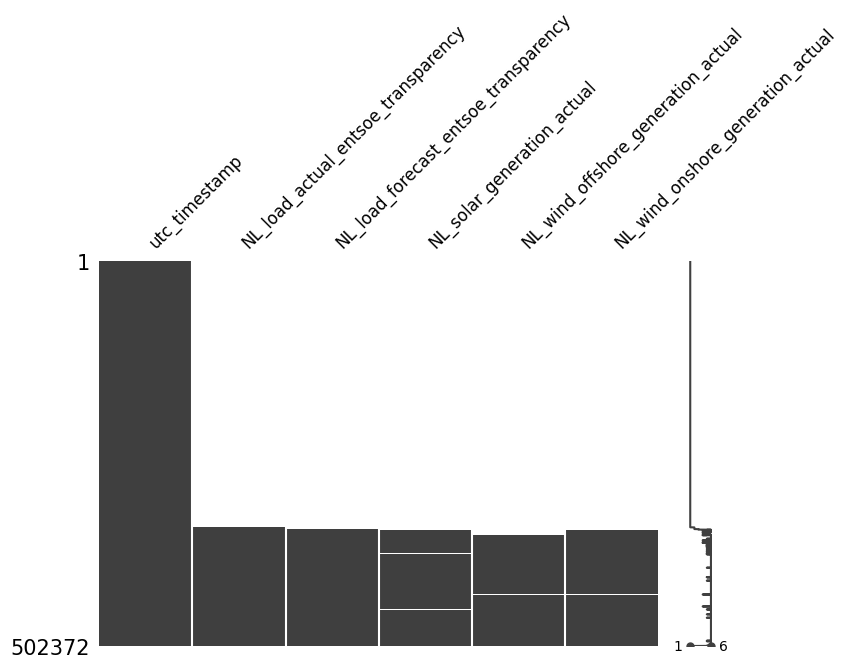

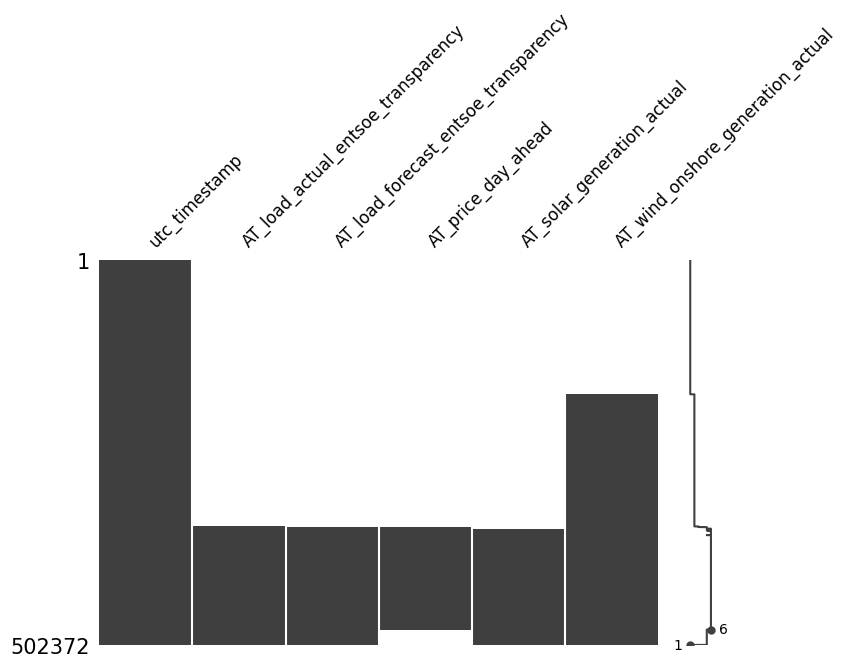

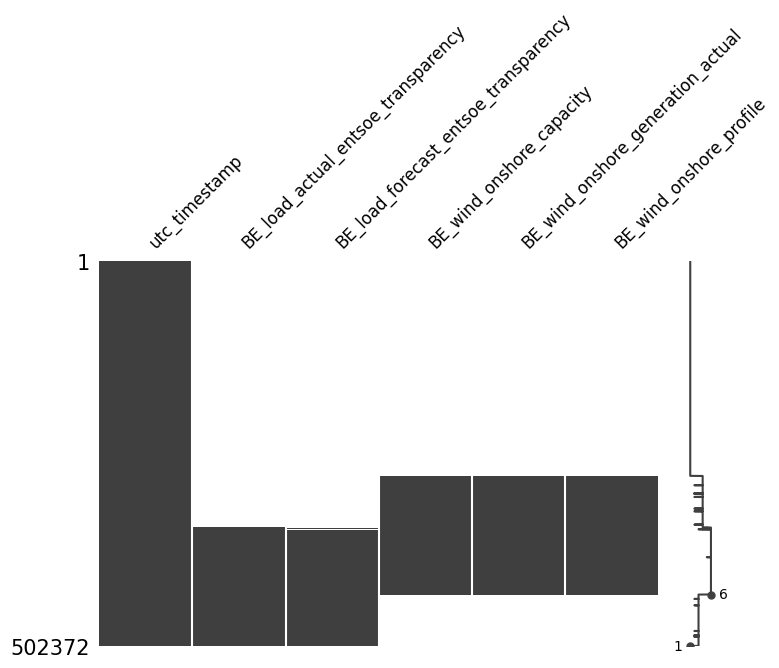

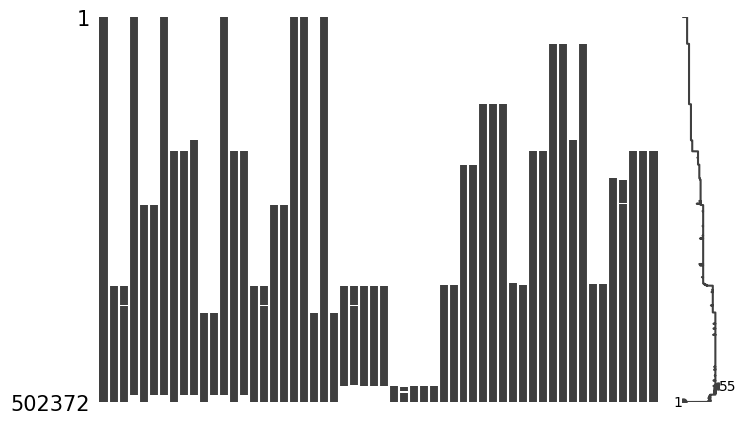

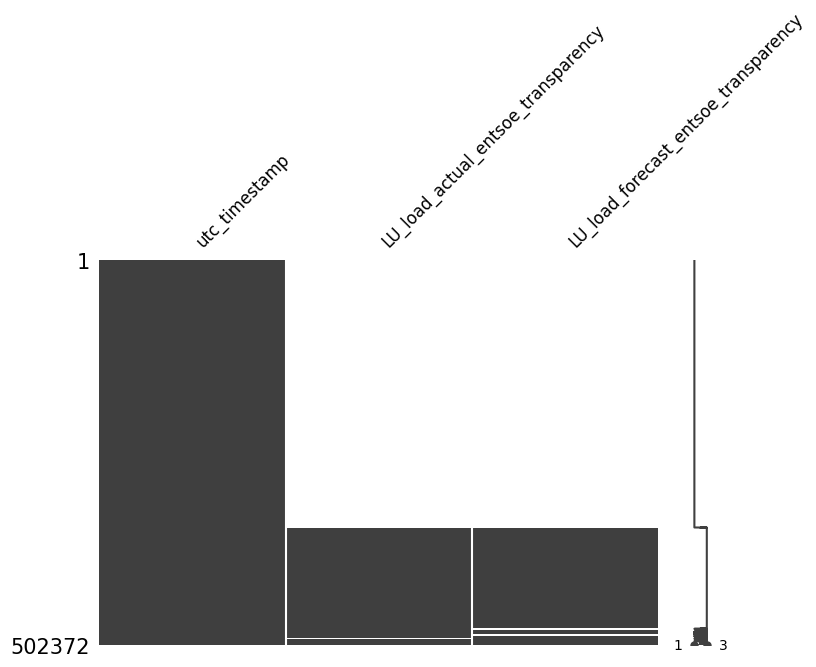

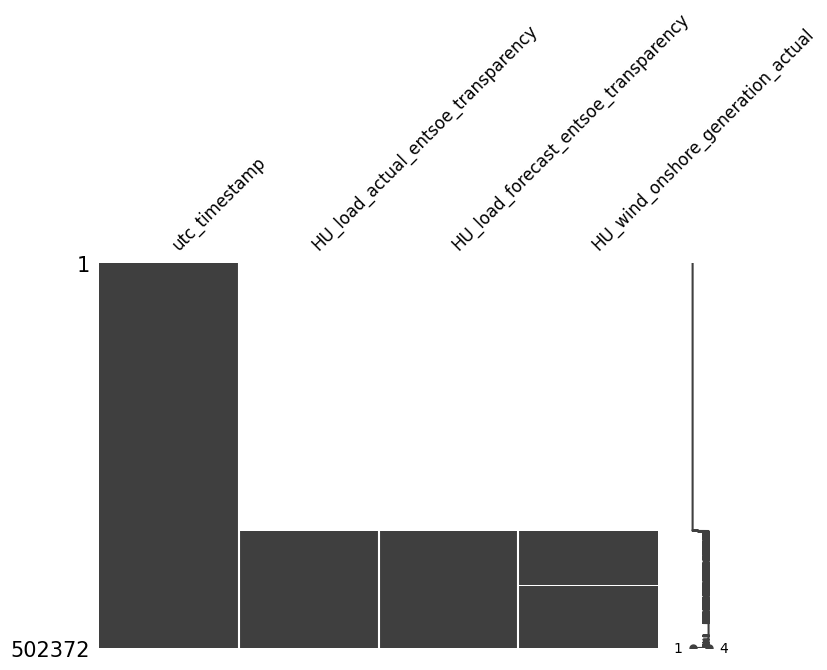

In [136]:
list_countries = pd.DataFrame({
'Country': ['Netherlands', 'Luxembourg', 'Austria', 'Hungary', 'Belgium', 'Germany'],
'Abbreviation': ['NL', 'LU', 'AT', 'HU', 'BE', 'DE']
})

list_countries

country_dfs = country_level_variables(energy_15_raw)
country_missing_dt(country_dfs)

Limit data to where there is available load_actuals across countries

In [137]:
# Get minimum lower bound time data available for each country

lower_bounds = []
for abbreviation, data in country_dfs.items():
    var = abbreviation + '_load_actual_entsoe_transparency'
    # "First Data Available (fdw)" data
    fdw_data = country_dfs[abbreviation][[var, 'utc_timestamp']].dropna()
    data_start = min(fdw_data.utc_timestamp)
    # Eariest datetime where data is available
    lower_bound_row = fdw_data[fdw_data['utc_timestamp']==data_start].index.values.astype(int)[0]
    lower_bounds.append(lower_bound_row)

print(f"First row of available data: {lower_bounds}")

# max row number is the minimum utc_timestamp with data available
energy_15_bounded = energy_15_raw.iloc[max(lower_bounds):] 
energy_15_bounded.shape
print(f'Days of data available: {energy_15_bounded.shape[0] / (4 * 24):.2f}')
print(f"Data range from {energy_15_bounded['utc_timestamp'].min()} to {energy_15_bounded['utc_timestamp'].max()}")


First row of available data: [347621, 347713, 347621, 350593, 349101, 349729]


(151779, 77)

Days of data available: 1581.03
Data range from 2014-12-31T23:15:00Z to 2019-04-30T23:45:00Z


Country: NL has 6 columns
Country: AT has 6 columns
Country: BE has 6 columns
Country: DE has 56 columns
Country: LU has 3 columns
Country: HU has 4 columns


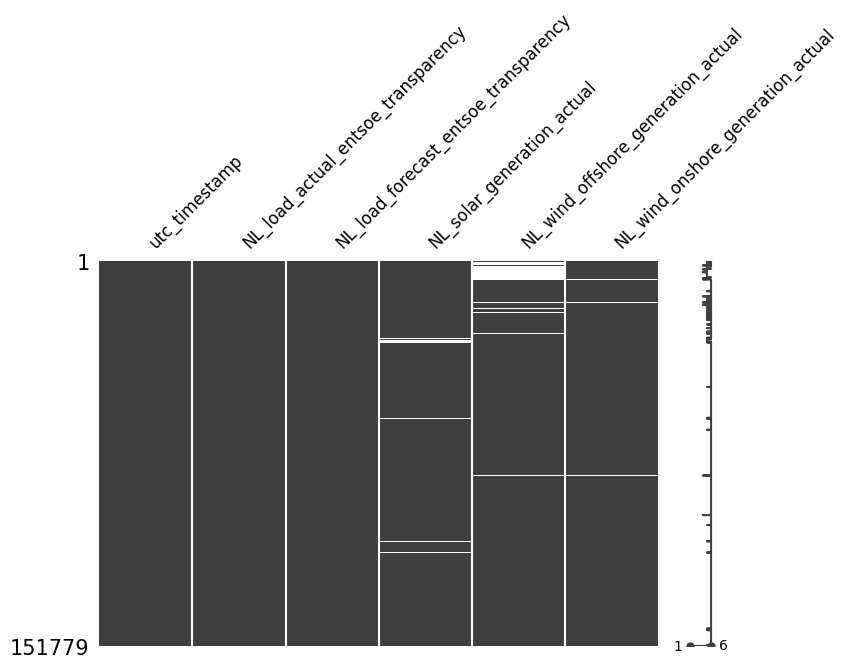

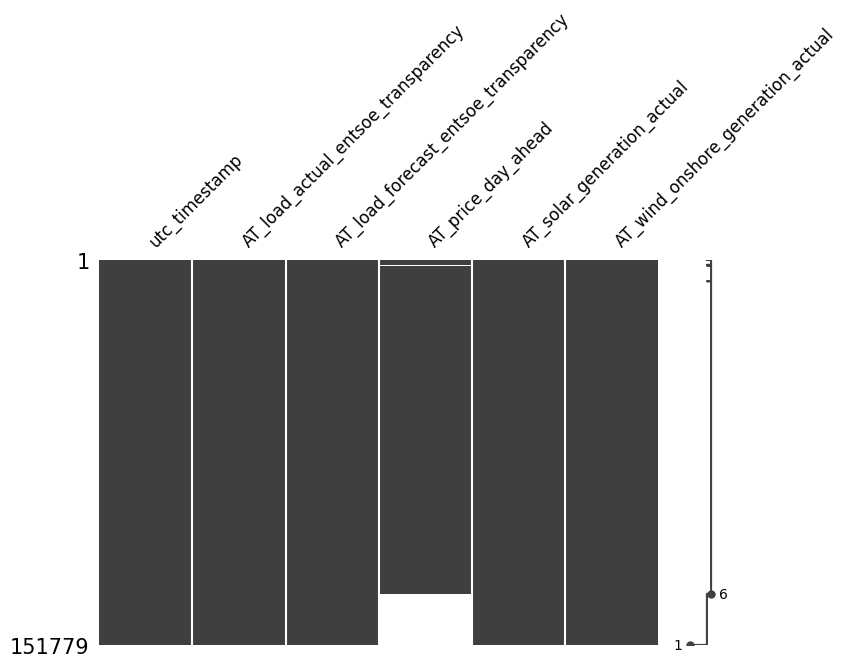

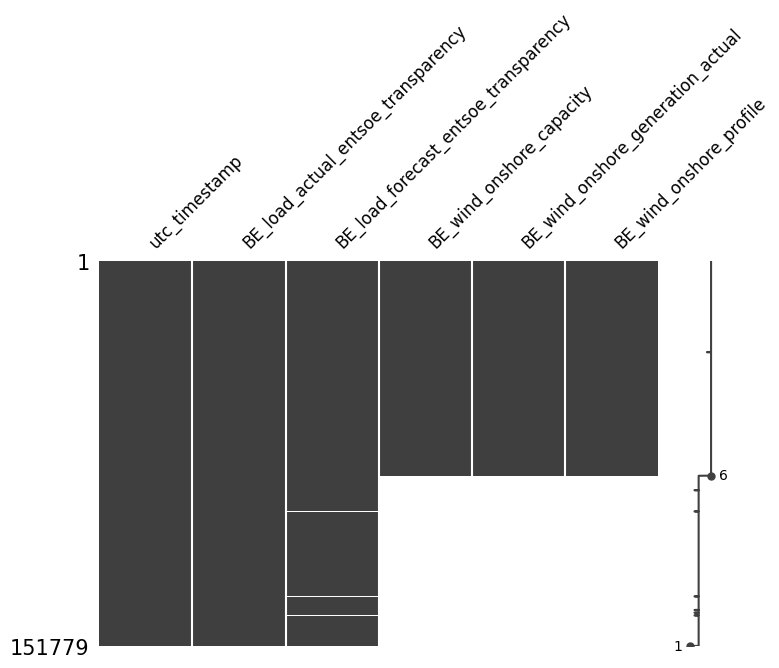

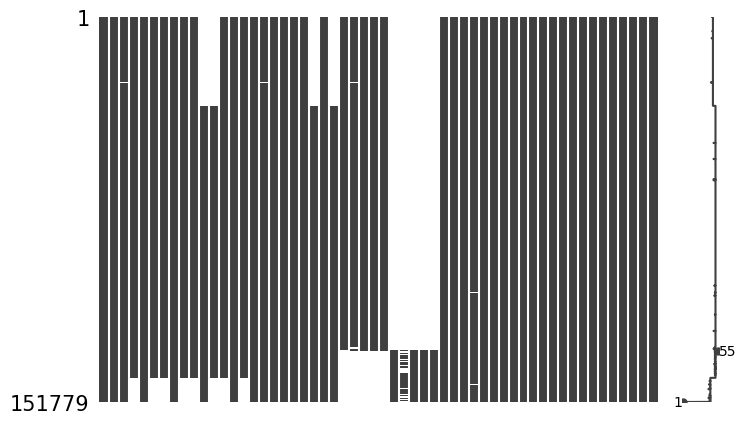

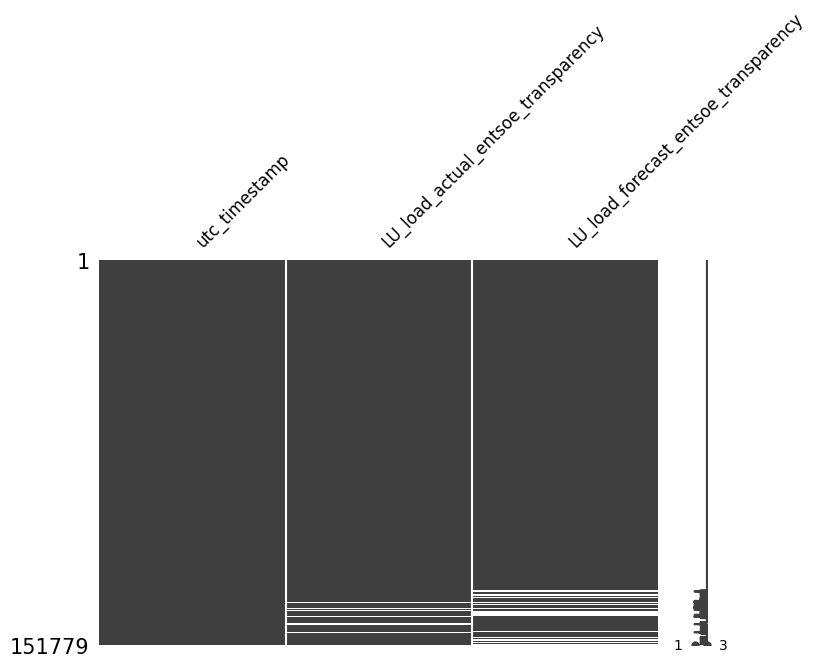

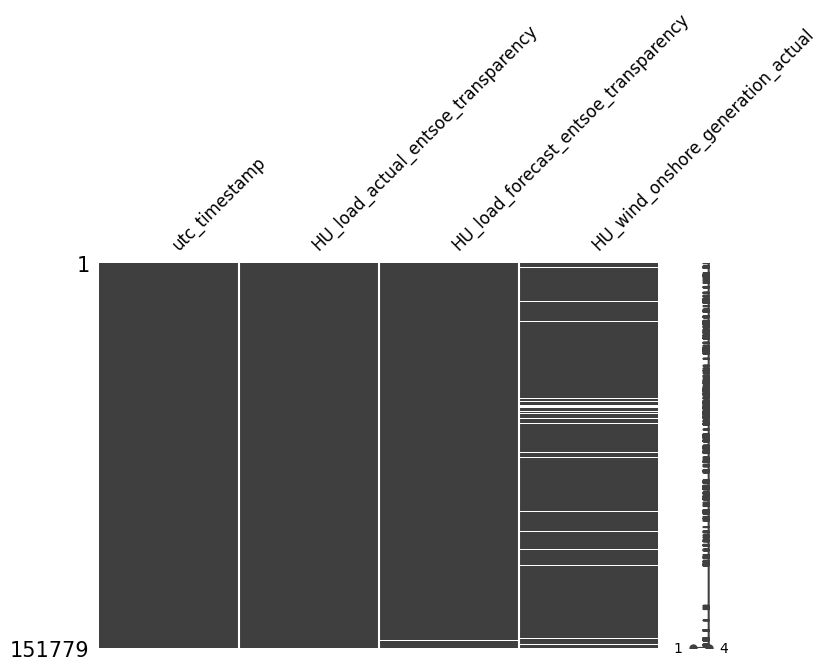

In [138]:
country_dfs_bounded = country_level_variables(energy_15_bounded)
# country_dfs_bounded
country_missing_dt(country_dfs_bounded)

In [139]:
de_df = country_dfs_bounded['DE']
country_dfs_bounded['DE'].head(5)

,utc_timestamp,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,DE_wind_offshore_capacity,...,DE_tennet_wind_generation_forecast,DE_tennet_wind_offshore_generation_actual,DE_tennet_wind_onshore_generation_actual,DE_transnetbw_load_actual_entsoe_transparency,DE_transnetbw_load_forecast_entsoe_transparency,DE_transnetbw_solar_generation_actual,DE_transnetbw_solar_generation_forecast,DE_transnetbw_wind_generation_actual,DE_transnetbw_wind_generation_forecast,DE_transnetbw_wind_onshore_generation_actual
350593,2014-12-31T23:15:00Z,42020.59,42412.03,37759.0,0.0,0.0,37586.0,8609.0,0.2290,1001.0,...,4182.0,469.0,3612.0,5452.51,4996.0,0.0,0.0,3.0,0.0,3.0
350594,2014-12-31T23:30:00Z,42067.64,41901.07,37759.0,0.0,0.0,37586.0,8674.0,0.2308,1001.0,...,4273.0,466.0,3555.0,5470.49,4962.0,0.0,0.0,5.0,0.0,5.0
350595,2014-12-31T23:45:00Z,41873.99,41354.93,37759.0,0.0,0.0,37586.0,8661.0,0.2304,1001.0,...,4365.0,467.0,3522.0,5437.84,4888.0,0.0,0.0,5.0,0.0,5.0
350596,2015-01-01T00:00:00Z,41230.04,40710.38,37759.0,0.0,0.0,37586.0,8699.0,0.2314,1001.0,...,4427.0,468.0,3467.0,5385.84,4761.0,0.0,0.0,4.0,0.0,4.0
350597,2015-01-01T00:15:00Z,40809.76,40204.18,37759.0,0.0,0.0,37586.0,8819.0,0.2346,1001.0,...,4456.0,469.0,3419.0,5370.14,4752.0,0.0,0.0,5.0,0.0,5.0


This section creates the country_actuals dataframe, which is the raw dataset limited to where there are values for the load actual variable. It consists of the 'utc_timestamp', 'country', 'load_actual_entsoe_transparency' variables. It is the primary dataframe for the remainder of eda

In [140]:
# Limit country data to time and load variable
dfs = country_level_variables(energy_15_bounded, load_only=True)
country_actuals = pd.DataFrame({})
for abbreviation, data in dfs.items():
    # Consolidate
    name = abbreviation + '_load_actual_entsoe_transparency'
    # New dataframe with timestamp, country, and load_actual
    data = (data.assign(utc_timestamp = pd.to_datetime(data.utc_timestamp),
                        country = abbreviation)
                .rename(columns = {name: 'load_actual_entsoe_transparency'})
                [['utc_timestamp', 'country', 'load_actual_entsoe_transparency']]) 
    country_actuals = pd.concat([country_actuals, data])

country_actuals = country_actuals.reset_index(drop=True)

country_actuals


,utc_timestamp,country,load_actual_entsoe_transparency
0,2014-12-31 23:15:00+00:00,NL,9819.00
1,2014-12-31 23:30:00+00:00,NL,9790.00
2,2014-12-31 23:45:00+00:00,NL,9718.00
3,2015-01-01 00:00:00+00:00,NL,9622.00
4,2015-01-01 00:15:00+00:00,NL,9524.00
...,...,...,...
910669,2019-04-30 22:45:00+00:00,HU,4349.16
910670,2019-04-30 23:00:00+00:00,HU,4320.76
910671,2019-04-30 23:15:00+00:00,HU,4238.78
910672,2019-04-30 23:30:00+00:00,HU,4140.88


### Country Level Electricity Time Series

The following source details the data processing: 
https://github.com/Open-Power-System-Data/time_series/blob/885c0946fe57d1a2f44f7bc57306e87811e4e2e8//processing.ipynb

- Missing data is handled with linear interprolation

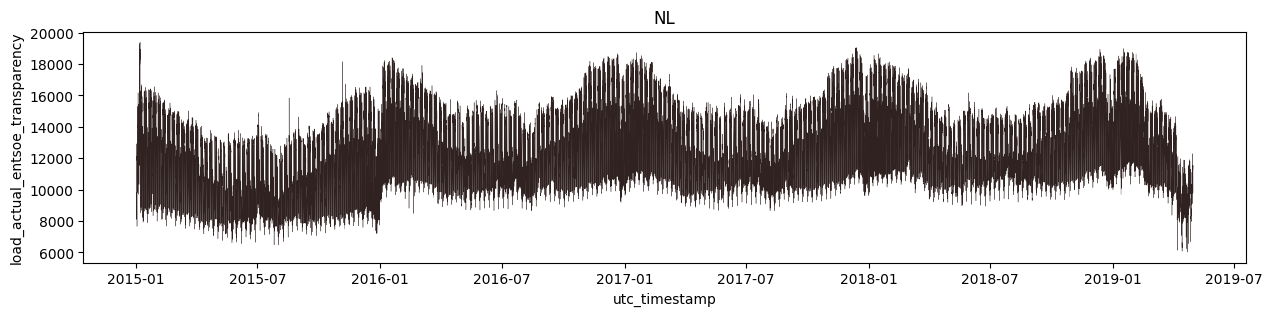

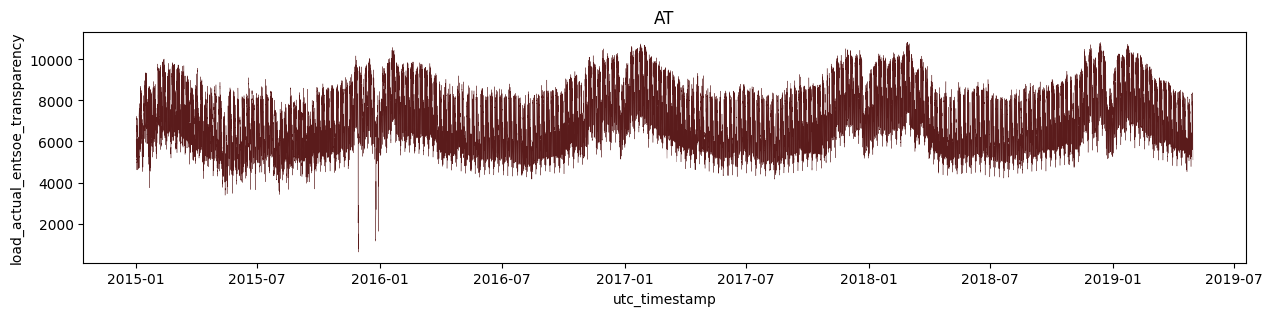

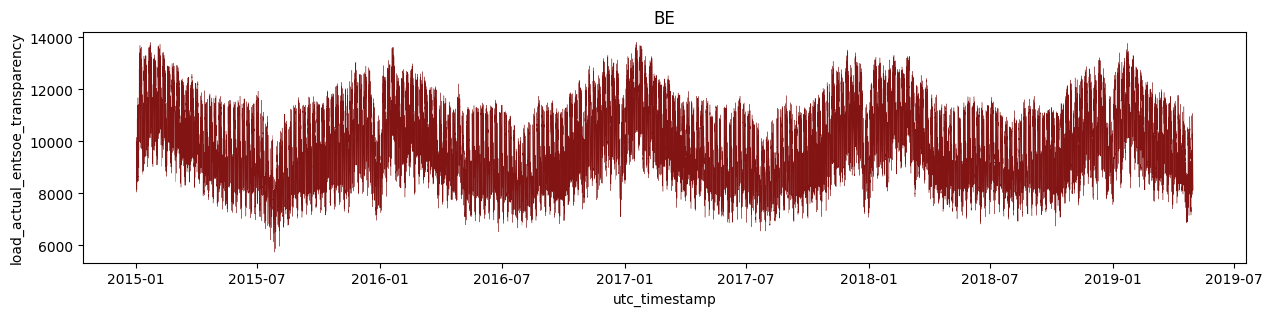

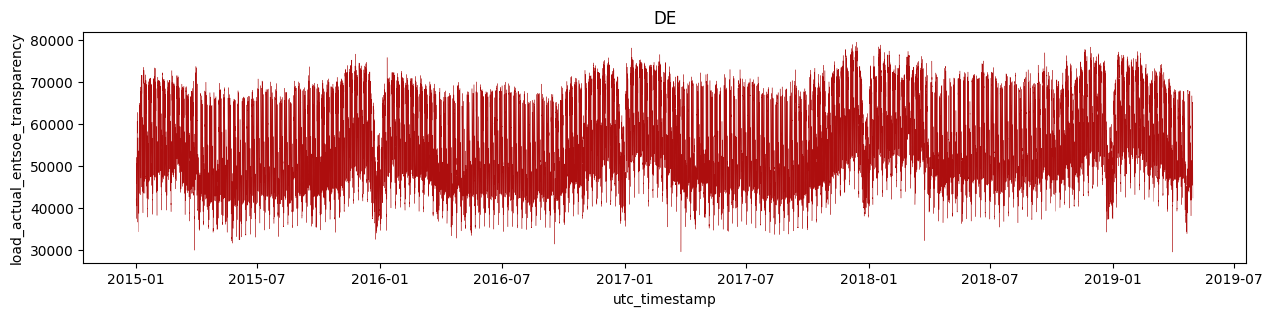

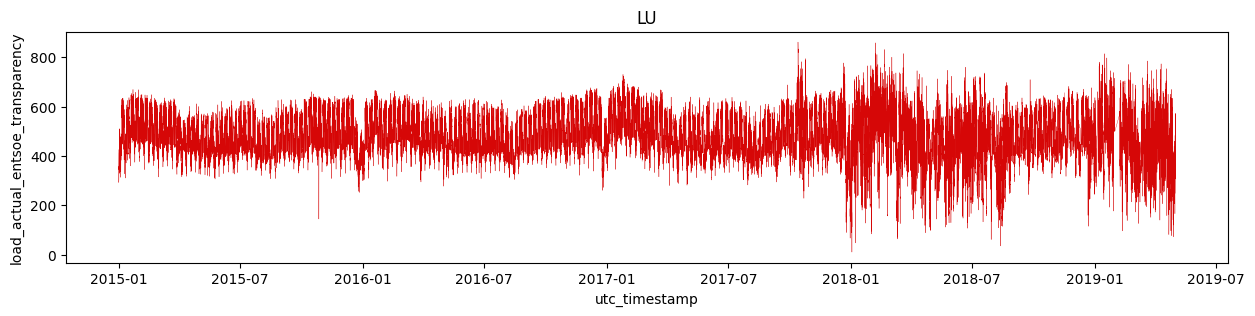

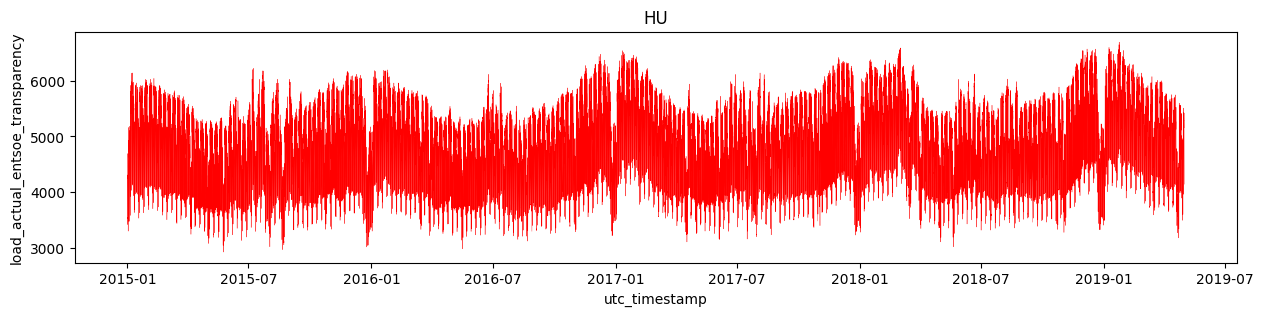

In [141]:
colors = ['#D91A1A', '#B41C1C', '#8F1D1E', '#6B1F20', '#462022', '#212224']
all_countries = country_actuals['country'].unique()
palette = sns.color_palette("dark:red", len(all_countries)) # mako # magma


for country, color in zip(country_actuals['country'].unique(), palette):  
    plot_dt = country_actuals.loc[lambda x: x.country == country]

    _ = plt.figure(figsize=(15, 3))

    _ = sns.lineplot(
        data=plot_dt, 
        x='utc_timestamp', 
        y='load_actual_entsoe_transparency', 
        color=color,
        linewidth=0.25)
    _ = plt.title(country)

    plt.show()



Notes:
- Notable variance in Lithuania's electricity usage beginning in 2018.
- Why is electricity usage drastically lower at the end of the year for each country?

In [142]:
country_actuals.head()


,utc_timestamp,country,load_actual_entsoe_transparency
0,2014-12-31 23:15:00+00:00,NL,9819.0
1,2014-12-31 23:30:00+00:00,NL,9790.0
2,2014-12-31 23:45:00+00:00,NL,9718.0
3,2015-01-01 00:00:00+00:00,NL,9622.0
4,2015-01-01 00:15:00+00:00,NL,9524.0


Saving Data (Consider Removing)

In [11]:
# Filepath to save data: C:/Users/WulfN/datasets/country_energy
# save dataset limited to load data
## current_dir = str(Path.cwd())

# country_actuals.to_csv(current_dir + '/country_energy/country_load_actuals.csv')

Adding Features - need to resolve week variable

In [12]:
# Add features
def add_time_features(df): # requires country_actuals dataframe
    us_holidays = holidays.US(years=range(2014, 2021))
    # day level date
    df['day'] = df['utc_timestamp'].dt.date
    # hour
    df['hour'] = df['utc_timestamp'].dt.hour
    # week - would like first week to be 0 and last week to by multiple of year * week 
    df['week1'] = df['utc_timestamp'].dt.isocalendar().week
    # weekend indicator variable
    df['is_weekend'] = df['utc_timestamp'].dt.dayofweek.isin([5, 6]).astype(int)
    # holiday indicator variable
    df['is_holiday'] = df['utc_timestamp'].dt.date.isin(us_holidays).astype(int)

    return df

country_actuals_plus = add_time_features(country_actuals)

# for clusters
# country_actuals['day_hour'] = country_actuals['utc_timestamp'].dt.hour

### Consider hourly stats (aggregate from 15min to 1 hour)
# country_actuals = country_actuals.groupby([])



Is Average Daily load shape different across countries? (If making modeled features, do they need to be at the country level?)

In [143]:
# Experimentation Cell (delete later)
# def plot_norm_avg_hourly(df, group, pivot=True): # requires df from hourly_pivot function
#     '''
#     Description: min-max normalization of input data across each hour
#     '''
#     df = df.groupby(by=group, as_index=True).mean().round(2)
#     # hour columns
#     cols = list(range(24))

#     # columns for row-wise min-max normalization
#     df['min'] = df[cols].min(axis=1)
#     df['max'] = df[cols].max(axis=1)

#     # Row-wise Min-max normalization 
#     df[cols] = (df[cols].sub(df['min'], axis=0)
#                         .div(df['max'] - df['min'], axis=0))
    
#     # Melt for overlapping lineplots
#     if pivot:
#         df = (df.reset_index()
#                 .melt(id_vars=group,
#                       value_vars=cols)
#                 .assign(hour = lambda x: pd.to_numeric(x.hour))
#                 )
        
#     return df

day_pivot_hourly = hourly_pivot(country_actuals_plus)
day_pivot_hourly_2 = day_pivot_hourly.reset_index().set_index('day')

# day_pivot_hourly
# day_pivot_hourly_2

plot_norm_avg_hourly(day_pivot_hourly_2, 'country', pivot=True)

,country,hour,value
0,AT,0,0.054375
1,BE,0,0.102475
2,DE,0,0.017599
3,HU,0,0.087277
4,LU,0,0.210170
...,...,...,...
139,BE,23,0.238615
140,DE,23,0.087020
141,HU,23,0.208853
142,LU,23,0.393485


hour,country,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
2015-01-01,AT,23854.00,22904.00,21387.20,20996.00,21234.80,22298.00,23701.20,25372.00,27527.60,...,26171.60,26412.80,26939.20,26504.00,26954.00,26616.40,25020.00,24885.60,23456.80,22132.40
2015-01-01,BE,38020.59,36431.55,35012.63,34084.89,33763.46,33524.79,32303.88,32532.49,33172.22,...,35468.75,35860.17,38328.59,39403.53,39135.98,38006.52,37391.42,39389.11,40016.62,37774.14
2015-01-01,DE,162660.43,158039.41,154148.25,152610.60,151708.22,151684.25,156573.71,159565.14,166472.22,...,185389.02,192919.51,206534.70,205228.61,200550.93,188367.25,180727.58,197459.13,185872.52,173014.00
2015-01-01,HU,16276.73,15019.69,14041.56,13706.74,13750.03,13986.29,14182.51,14683.77,15507.74,...,17117.79,18340.21,18668.74,18531.47,18433.73,18053.77,17537.23,16824.28,16008.37,15023.85
2015-01-01,LU,1615.00,1533.00,1480.00,1455.00,1415.00,1198.00,1230.00,1208.00,1199.00,...,1380.00,1412.00,1585.00,1644.00,1583.00,1509.00,1436.00,1716.00,1669.00,1564.00


,country,hour,value
0,AT,0,0.054375
1,BE,0,0.102475
2,DE,0,0.017599
3,HU,0,0.087277
4,LU,0,0.210170


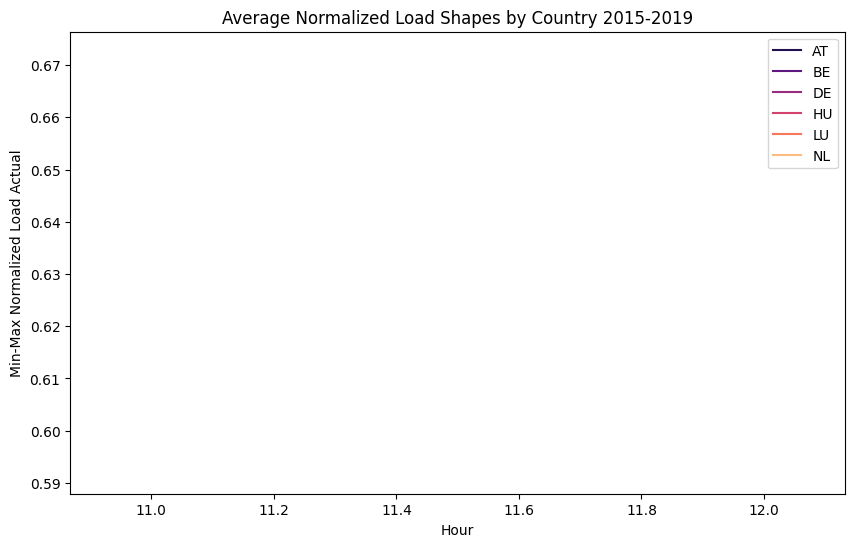

In [144]:
# pivot to so hours are columns 
day_pivot_hourly = hourly_pivot(country_actuals_plus)
day_pivot_hourly.head(5)
# transform and normalize data for time series plots
avg_hourly = plot_norm_avg_hourly(day_pivot_hourly, 'country')
avg_hourly.head(5)
# plot overlapping load shapes
multi_lineplots(avg_hourly, group='country')

- The above load shape graph suffers from there not being weather data, and as a result the distribution is bimodal, whereas we would expect there to be peak usage in either the morning or the afternoon depending on if it was a CDD or a HDD. 

- Lithuania's load shape appears to be off by 1 hour due to different time zone, adjusting that

Shifting Country Actuals for Lithuania back 1 hour

(910674, 910674)

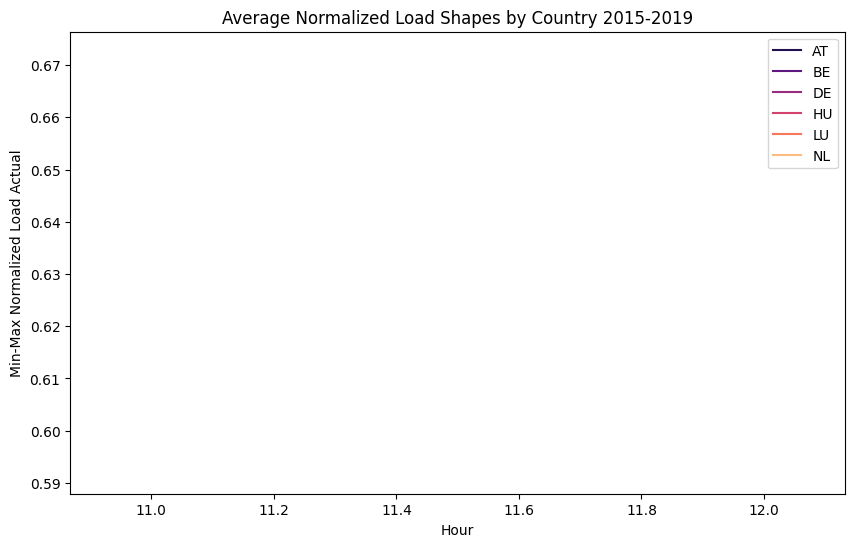

In [132]:
# Adjust Lithuania load shape, insert back into dataframe
LU_time_adjustment = (country_actuals.loc[country_actuals.country == 'LU']
                                     .assign(utc_timestamp = lambda x: x.utc_timestamp - pd.Timedelta(hours=1)))

# Re-insert Lithuania with time adjusted 
country_actuals_2 = pd.concat(
    [country_actuals.loc[country_actuals.country != 'LU'], LU_time_adjustment])

# ensure dataframes are of same length
len(country_actuals), len(country_actuals_2)

# add time features (again), transform data for normalized plots
country_actuals_2_plus = add_time_features(country_actuals_2)
day_pivot_hourly = hourly_pivot(country_actuals_2)
plot_df = plot_norm_avg_hourly(day_pivot_hourly, 'country')
multi_lineplots(plot_df, group='country')


- After the timezone adjustment for Lithuania, the Average Daily loadshapes are similar between countries.
- Lithuania's load shape dips around hours 12-15. 
    - In 2018 Lithuania began integrating their energy grid with the Synchronous grid of Continental Europe. Uncertain what affect this had on Lithuania's comparitively volatile electricity usage during this time. 

Creating longitudinal clusters given simularity of average load shapes between countries.

In [114]:
# Remove 'country' from index for data filtering
day_pivot_hourly_2 = day_pivot_hourly.reset_index()

# Seperate to train/test data and validation data
days_remove = (6 * 7) - 1 # Remove 7 days for 6 countries
train_test_clusters = day_pivot_hourly_2.loc[lambda x: ~x.day.isin(day_pivot_hourly_2[-days_remove:]['day'].unique())]
validation = day_pivot_hourly_2[-days_remove:] 

# Set day as index for later clustering
train_test_clusters = train_test_clusters.set_index('day')

# Min-max normalize hours at the day and country level
train_test_clusters = plot_norm_avg_hourly(train_test_clusters, ['day', 'country'], pivot=False) # need row-wise min max

# Drop days with missing data (Lithuania late 2019-2019) 
train_test_clusters = train_test_clusters.loc[lambda x: x['min'] != 0].set_index('country')

C:\Users\WulfN\AppData\Local\Temp\ipykernel_19840\797160345.py:119: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  df = df.groupby(by=group, as_index=False).mean().round(2)


array(['AT', 'BE', 'DE', 'HU', 'LU', 'NL'], dtype=object)

In [115]:
from sklearn.cluster import AgglomerativeClustering as aggclust
import numpy as np
np.random.seed(12)

# Remove warnings when making columns with clusters
pd.options.mode.chained_assignment = None

# Dataframe of hours 0 through 23
X = train_test_clusters[list(range(24))]
# replace NAs?
# pipeline will not be robust if NAs aren't allowed

# Max number of clusters to create
n = 8
for i in range(2,n):
    # Column name (based on cluster number i)
    var_name = 'c'+str(i)
    # Assign results of hierarchical clustering
    train_test_clusters.loc[:, var_name] = aggclust(
        n_clusters=i,
        linkage='ward' # metric must be euclidean
        ).fit(X).labels_


In [ ]:
test = train_test_clusters
test.groupby('c5', as_index=True).mean().reset_index() # 'c5'

#test[['country',0,1,2,3,4]]


hour,c5,0,1,2,3,4,5,6,7,8,...,21,22,23,min,max,c2,c3,c4,c6,c7
0,0,0.311941,0.224586,0.176939,0.140057,0.133633,0.173682,0.274516,0.407432,0.519551,...,0.636191,0.510581,0.354782,27094.244558,37804.863847,0.0,2.0,2.0,4.372654,4.372654
1,1,0.065102,0.018143,0.017903,0.094952,0.313426,0.624659,0.820992,0.895477,0.916493,...,0.481337,0.330766,0.193441,46416.611318,68612.710522,1.0,0.0,1.0,0.000000,1.874463
2,2,0.168492,0.087747,0.048840,0.039329,0.096656,0.238252,0.431651,0.619812,0.758798,...,0.568434,0.413198,0.261729,39063.679455,54289.549189,0.0,1.0,0.0,2.000000,2.000000
3,3,0.057183,0.040090,0.083206,0.208777,0.477179,0.722627,0.854908,0.908625,0.948818,...,0.304793,0.167286,0.070132,63626.339614,99389.281946,1.0,0.0,3.0,1.000000,1.000000
4,4,0.101521,0.043189,0.019626,0.033120,0.116468,0.301500,0.582514,0.788443,0.885800,...,0.452930,0.288550,0.135156,43086.212516,63402.856203,0.0,1.0,0.0,4.000000,4.000000


In [ ]:
# counts by cluster
clusters = ['c2', 'c3', 'c4', 'c5', 'c6', 'c7']

for clust in clusters: # Clusters selected: \n{train_test_clusters[clust].value_counts()}
    print(f"Value Counts when {clust[1]} \n Percents: {(train_test_clusters[clust].value_counts()*100 / (len(train_test_clusters))).round(2)}")

In [ ]:
def multi_lineplots(plot_df, group, clusters=False): # requires df from norm_avg_hourly function  
    '''
    Description: Creates overlapping line plots for each country given a dataframe
    from the 'norm_avg_hourly' function.
    '''
    colors = sns.color_palette('magma')
    _ = plt.figure(figsize=(10, 6))

    if clusters==False:
        for grouping, color in zip(plot_df[group].unique(), colors):
            line_plot = plot_df.groupby(group, as_index=False).mean().reset_index()
            _ = sns.lineplot(
                data=line_plot,
                x='hour', # cannot use hour here - why?
                y='value',
                color=color,
                label = str(grouping)
            )
        _ = plt.xlabel('Hour')
        _ = plt.ylabel('Min-Max Normalized Load Actual')
        _ = plt.title('Normalized Load Shapes of Countries Averaged Over Year')
        
    # if clusters:
    #     line_plot = plot_df.groupby(group, as_index=False).mean()
    #     line_plot = plot_norm_avg_hourly(line_plot, group)
    #     # for grouping, color in zip(plot_df[group].unique(), colors):
    #     #     _ = sns.lineplot(
    #     #         data=line_plot,
    #     #         x='hour',
    #     #         y='value',
    #     #         color=color,
    #     #         label = str(grouping)
    #     #         )
    #     #     _ = plt.xlabel('Hour')
    #     #     _ = plt.ylabel('Min-Max Normalized Load Actual')
    #     #     _ = plt.title('Normalized Load Shapes of Countries Averaged Over Year')
    
    plt.show()

# Test with reset_index() - should be that country in index is preferable
# train_test_clusters_2 = train_test_clusters.reset_index()
# train_test_clusters_2.info()
#train_test_clusters['c5'] = train_test_clusters['c5'].astype(str)
# Goals: 
#   - plot the resulting load shapes, and compare
# clusters
# for clust in clusters:
# clust_false = multi_lineplots(train_test_clusters, 'c5', clusters=False) # clust
# country_clust_false = multi_lineplots(train_test_clusters, 'country', clusters=False) # clust
# clust_true = multi_lineplots(train_test_clusters, 'c5', clusters=True)
# clust_false
# country_clust_false
# clust_true

# train_test_clusters['c7'].unique()
# line_plot = train_test_clusters.groupby('c3', as_index=False).mean()
# line_plot
    

In [126]:
train_test_clusters

hour,0,1,2,3,4,5,6,7,8,9,...,22,23,min,max,c2,c3,c4,c5,c6,c7
country,,,,,,,,,,,,,,,,,,,,,
AT,0.378683,0.252809,0.051834,0.000000,0.031641,0.172514,0.358438,0.579818,0.865434,0.908363,...,0.326055,0.150572,20996.00,28543.20,0,1,0,2,2,2
BE,0.741204,0.535176,0.351205,0.230918,0.189243,0.158298,0.000000,0.029641,0.112585,0.287550,...,1.000000,0.709250,32303.88,40016.62,0,2,2,0,3,3
DE,0.200111,0.115863,0.044922,0.016889,0.000437,0.000000,0.089142,0.143680,0.269605,0.432934,...,0.623300,0.388871,151684.25,206534.70,0,2,2,0,5,5
HU,0.517934,0.264601,0.067477,0.000000,0.008724,0.056338,0.095883,0.196902,0.362958,0.515625,...,0.463851,0.265439,13706.74,18668.74,0,2,2,0,5,5
LU,0.646718,0.544402,0.496139,0.418919,0.000000,0.061776,0.019305,0.001931,0.113900,0.353282,...,0.706564,0.486486,1198.00,1716.00,0,2,2,0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BE,0.003580,0.000000,0.014364,0.207894,0.478286,0.773952,0.916757,1.000000,0.989691,0.990932,...,0.408871,0.271553,27750.82,41856.67,1,0,1,1,0,0
DE,0.000000,0.004706,0.063982,0.205962,0.492607,0.699269,0.832383,0.884692,0.935907,0.989767,...,0.271641,0.211308,155451.79,271323.95,1,0,3,3,1,1
HU,0.005662,0.000000,0.069771,0.220459,0.541603,0.779506,0.842182,0.909654,0.942116,0.970024,...,0.501359,0.421843,13413.80,22284.96,1,0,1,1,0,0


In [130]:
multi_lineplots(train_test_clusters, group='country')

KeyError: 'country'

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Goal: Automate creating lineplots of clusters

9444

In [ ]:
# For ts plots of clusters

# avg by cluster plotted

# min-max normalization, overlay clusters?
    # avg + sphaghetti plot by cluster?

In [ ]:
# once clusters exist, split data for training testing of lightgbm model

X_train, X_test, y_train, y_test = train_test_split(--, test_size = 0.2, random_state = 41, shuffle=False)
X_train
min(X_train['day'])

In [ ]:
# selecting different methods for seasonality

# or just pivot and graph to see if different average load shapes by country
    # should I build a longitudinal clustering model that on all country data, or should it be at the country level? 

